In [1]:
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import random
import matplotlib.pyplot as plt

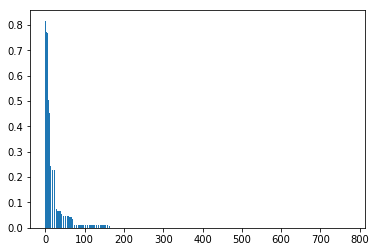

C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


NA % in prominent variables: 
 sensor_8      0.072091
sensor_87     0.011071
sensor_97     1.000000
sensor_140    0.010384
sensor_167    0.011071
dtype: float64


Nas remaining 0


In [9]:
dat1="C:/Users/Anthony/Desktop/Uptake Data Science Case Question/training.csv"
weather1="C:/Users/Anthony/Desktop/Uptake Data Science Case Question/weather.csv"
test1="C:/Users/Anthony/Desktop/Uptake Data Science Case Question/testing.csv"
revenue1="C:/Users/Anthony/Desktop/Uptake Data Science Case Question/revenue.csv"

dat=pd.read_csv(dat1)
test=pd.read_csv(test1)
weather=pd.read_csv(weather1)
revenue=pd.read_csv(revenue1)

#Reorder columns so prominent variables first:
cols=['id','site','inspect']+list(test)[:-3]
test=test[cols]

cols= ['id','site','status','repair_cost'] + list(dat)[:-4]
dat=dat[cols]




#MERGE TRAIN AND WEATHER

#Reformat weather's "site" column to only include site number (instead of string)
weather_sites=[]
for i in weather.loc[:,'site']:
    weather_sites.append(int(i.split("_")[1]))

for i in range(len(weather.loc[:,"site"])):
    weather.loc[i,"site"] = weather_sites[i]

#Merge with train data set
dat = dat.merge(weather,on='site')

#ENCODING

#Make 'status' have 1=online, 0=break
dat.loc[:,'status'] = LabelBinarizer().fit_transform(dat.loc[:,'status'])


#Lightning
dat["lightning_prob"]=dat["lightning_prob"].fillna(value="None")
dat=pd.concat((dat,pd.get_dummies(dat.loc[:,'lightning_prob'])), axis=1)
dat = dat.drop(['lightning_prob'], axis = 1)
#rename
cols = list(dat)[:-3] + ['Lightning_High', 'Lightning_Low', 'Lightning_None']
dat.columns = cols


#Encode sensor_97 
dat=pd.concat((dat,pd.get_dummies(dat.loc[:,'sensor_97'])), axis=1)
dat = dat.drop(['sensor_97'], axis = 1)

#Encode precipitation
dat=pd.concat((dat,pd.get_dummies(dat.loc[:,'precipitation'])), axis=1)
dat = dat.drop(['precipitation'], axis = 1)


#Encode sensor_21 (i.e. long list of codes)
dat=pd.concat((dat,pd.get_dummies(dat.loc[:,'sensor_21'])), axis=1)
dat=dat.drop(['sensor_21'], axis = 1)


#Encode site (i.e. long list of codes)
dat=pd.concat((dat,pd.get_dummies(dat.loc[:,'site'])), axis=1)
site_ref_dat=dat.loc[:,'site'].copy() #Used to join with predictions at end for profit calc
dat=dat.drop(['site'], axis = 1)
# cols = list(dat)[:370] + ????
# dat.columns = cols


#Remove 
dat=dat.drop(['sensor_5','sensor_146','sensor_153','sensor_1'], axis = 1) 



#Impute
#Fill in no repair cost with zero
dat["repair_cost"]=dat["repair_cost"].fillna(value=0)


#NA analysis
# #What % of each column are NA values?
y=pd.DataFrame(dat.isnull().sum()/len(dat.index)).sort_values(by=0,ascending=False)
plt.bar(np.array(range(len(y.index))),np.array(y.loc[:,0]))
plt.show()

#Rank of % having NaN -  guided variables of importance
print("NA % in prominent variables:","\n" ,dat.loc[:,["sensor_8","sensor_87","sensor_97","sensor_140","sensor_167"]].isnull().sum()/len(dat.index))

#Dropping high NA variables
vars_to_drop=list(y.loc[list(y.loc[:,0]>.25),:].index)
dat = dat.drop(vars_to_drop, axis = 1)

# #Impute rest of NAs
for i in list(dat)[2:]:
#     print(i)
    k=dat.loc[:,i].isnull().sum() #number of NAs to fill
#     print(k)
    try:
        if k != 0:      
            no_na_dat=list(dat.loc[dat.loc[:,i].notna(),i])
            fill_list = lambda x: random.choices(no_na_dat,k=k)
            fill_list = fill_list(no_na_dat)
            dat.loc[:,i] = dat.loc[:,i].fillna(pd.Series(np.random.choice(fill_list, size=len(dat.index))))
    except:
        pass
    


print("\n")
print("Nas remaining",np.sum(dat.isnull().sum()))




In [10]:
#TEST data

#Prep test data for prediction:

#Merge weather
test = test.merge(weather,on='site')


#ENCODING


#Lightning
test["lightning_prob"]=test["lightning_prob"].fillna(value="None")
test=pd.concat((test,pd.get_dummies(test.loc[:,'lightning_prob'])), axis=1)
test = test.drop(['lightning_prob'], axis = 1)
#rename
cols = list(test)[:-3] + ['Lightning_High', 'Lightning_Low', 'Lightning_None']
test.columns = cols


#Encode sensor_97 
test=pd.concat((test,pd.get_dummies(test.loc[:,'sensor_97'])), axis=1)
test = test.drop(['sensor_97'], axis = 1)

#Encode precipitation
test=pd.concat((test,pd.get_dummies(test.loc[:,'precipitation'])), axis=1)
test = test.drop(['precipitation'], axis = 1)

#Encode sensor_21 (i.e. long list of codes)
test=pd.concat((test,pd.get_dummies(test.loc[:,'sensor_21'])), axis=1)
test=test.drop(['sensor_21'], axis = 1)

#Encode site (i.e. long list of codes)
site_ref=test.loc[:,'site'].copy()
test=pd.concat((test,pd.get_dummies(test.loc[:,'site'])), axis=1)
test=test.drop(['site'], axis = 1)

#Remove for convenience
test=test.drop(['sensor_5','sensor_146','sensor_153','sensor_1'], axis = 1)


#Dropping high NA variables
y=pd.DataFrame(test.isnull().sum()/len(test.index)).sort_values(by=0,ascending=False)
vars_to_drop=list(y.loc[list(y.loc[:,0]>.25),:].index)
test = test.drop(vars_to_drop, axis = 1)


# #Impute rest of NAs
for i in list(test)[2:]:
    k=test[i].isnull().sum() #number of NAs to fill
    try:
        if k != 0:      
            no_na_dat=list(test.loc[test[i].notna(),i])
            fill_list = lambda x: random.choices(no_na_dat,k=k)
            fill_list = fill_list(no_na_dat)
            test.loc[:,i] = test.loc[:,i].fillna(pd.Series(np.random.choice(fill_list, size=len(test.index))))
    except:
        pass

    
#reattach site ref

test=pd.concat((site_ref,test),1)


In [11]:
#What does train have that test does not
reconcile_vars1=[]
for i in list(dat)[3:]:
    if i not in list(test)[3:]:
        reconcile_vars1.append(i)
reconcile_vars1

['fault_code_7FW90',
 'fault_code_KME1K',
 'fault_code_WQR5C',
 'fault_code_ZK6DM',
 'fault_code_ZNG46']

In [12]:
#What does test have that train does not
reconcile_vars2=[]
for i in list(test)[4:]:
    if i not in list(dat)[3:]:
        reconcile_vars2.append(i)
        
reconcile_vars2

['fault_code_0I5C7',
 'fault_code_3CU2K',
 'fault_code_7O1V1',
 'fault_code_8C6PZ',
 'fault_code_8EF6Z',
 'fault_code_B5X9U',
 'fault_code_BDXFH',
 'fault_code_BIXGE',
 'fault_code_BLBOS',
 'fault_code_C2Z8I',
 'fault_code_CKS0W',
 'fault_code_E8YVI',
 'fault_code_EELFJ',
 'fault_code_EUZ2V',
 'fault_code_GOPHO',
 'fault_code_HQRE7',
 'fault_code_JGET4',
 'fault_code_JLY5T',
 'fault_code_KS5XY',
 'fault_code_KZV2U',
 'fault_code_LBSEC',
 'fault_code_LDB3R',
 'fault_code_LHKVQ',
 'fault_code_LPUBG',
 'fault_code_LZPA8',
 'fault_code_M2L9T',
 'fault_code_M5DU3',
 'fault_code_MIQJR',
 'fault_code_MPJZ5',
 'fault_code_R30RL',
 'fault_code_SKOC8',
 'fault_code_T3JGB',
 'fault_code_VM08E',
 'fault_code_VR23X',
 'fault_code_WE65I',
 'fault_code_XPH15',
 'fault_code_ZAW7L',
 5,
 62,
 71]

In [13]:
dat=dat.drop(reconcile_vars1, axis = 1)
test=test.drop(reconcile_vars2, axis = 1)
list(dat)[3:]==list(test)[3:]

True

In [14]:
#Split data
train, val = train_test_split(dat, test_size = 0.2, random_state = 43)

#Put aside: ID, status, repair_cost
train_aside=train.iloc[:,:3]
val_aside=val.iloc[:,:3]

#Predictors
x_train=train.iloc[:,3:]
x_val=val.iloc[:,3:]

#Results
y_train = train.iloc[:,1]
y_val= val.iloc[:,1]

In [15]:
#Scale the data
std_scale = StandardScaler().fit(x_train)
train_standardized = std_scale.transform(x_train) 
test_standardized=std_scale.transform(x_val) 


print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)

C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


(9321, 754) (2331, 754) (9321,) (2331,)


C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [1365]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train)
x_train_pca=pca.transform(x_train)
x_test_pca=pca.transform(x_val)
x_train_pca.shape

(9321, 10)

In [1366]:
#First loading looks well to explain
pca.explained_variance_ratio_.cumsum()

array([0.99638379, 0.99794734, 0.99825344, 0.9984765 , 0.99867899,
       0.99885048, 0.99900527, 0.99913534, 0.99924814, 0.99934291])

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

In [1270]:
KNN=KNeighborsClassifier(n_neighbors=5, 
                     weights='uniform', 
                     algorithm='auto', #Automatically determines best method: Ball or KDTree
                     leaf_size=30, #For Ball tree or KDtree methods
                     p=2, #Euclidean distance
                     metric='minkowski', #If p=2 then this is just euclidean
                     metric_params=None, #Additional args (dict) for metric..
                     n_jobs=1)

KNN.fit(x_train,y_train)
KNN.score(x_val,y_val) 

0.9794079794079794

In [1399]:
mytree=DecisionTreeClassifier(criterion='gini', 
                       splitter='best', 
                       max_depth=None, 
                       min_samples_split=2, 
                       min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, 
                       max_features=None, 
                       random_state=None, 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=0.0, 
                       min_impurity_split=None, 
                       class_weight=None, 
                       presort=False)


mytree.fit(x_train,y_train)
mytree.score(x_val,y_val)

0.9764049764049764

In [1272]:
SVC=LinearSVC(penalty='l2', 
              loss='squared_hinge', 
              dual=True, 
              tol=0.0001, 
              C=1.0, 
              multi_class='ovr', 
              fit_intercept=True, 
              intercept_scaling=1, 
              class_weight=None, 
              verbose=0, 
              random_state=None, 
              max_iter=1000)
       
    
SVC.fit(x_train,y_train)
SVC.score(x_val,y_val)

C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9266409266409267

In [1273]:
MLP=MLPClassifier(hidden_layer_sizes=(200,200,200,100), 
                  activation='relu', #maybe Logistic?
                  solver='adam', #Adam optimizer works best for large sets, or ‘lbfgs’ for smaller ones.
                  alpha=0.0001, #L2 Regularization parameter to shrink parameters
                  batch_size='auto', 
                  learning_rate='constant', #maybe try ’adaptive’?
                  learning_rate_init=0.001, 
                  power_t=0.5, #The exponent for inverse scaling learning rate. Only used for sgd solver...
                  max_iter=200, 
                  shuffle=True, #shuffle samples before each iteration
                  random_state=None, 
                  tol=0.0001, 
                  verbose=False, 
                  warm_start=False, 
                  momentum=0.9, #0-1 float, Only used for sgd solver...
                  nesterovs_momentum=True, #Only used for sgd solver...
                  early_stopping=False, 
                  validation_fraction=0.1, #0-1 float, proportion of training aside for validation for early stopping.
                  beta_1=0.9, #0-1 float, Exponential decay rate for estimates of 1st moment vector in adam
                  beta_2=0.999, #0-1 float, Exponential decay rate for estimates of 2nd moment vector in adam
                  epsilon=1e-08)

MLP.fit(x_train,y_train)
MLP.score(x_val,y_val) 

0.9553839553839554

In [1274]:
models=[("tree",mytree),("knn",KNN),("mlp",MLP),("svc",SVC)]

ensemble=VotingClassifier(estimators=models, 
                          voting='hard', 
                          weights=None, 
                          n_jobs=None, 
                          flatten_transform=None)


ensemble.fit(x_train,y_train)
ensemble.score(x_val,y_val) 

C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9768339768339769

In [1275]:
Bags=BaggingClassifier(base_estimator=mytree,  
                  n_estimators=25, #How many to ensemble?
                  max_samples=1.0, 
                  max_features=1.0, 
                  bootstrap=True, 
                  bootstrap_features=False, 
                  oob_score=True, 
                  warm_start=False, 
                  n_jobs=1, 
                  random_state=1, 
                  verbose=0)

Bags.fit(x_train,y_train)
print(Bags.score(x_val,y_val)) 

0.9824109824109825


In [17]:
boost=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), 
                         n_estimators=10, 
                         learning_rate=1.0, 
                         algorithm='SAMME.R', 
                         random_state=None)

boost.fit(x_train,y_train)
print(boost.score(x_val,y_val)) #returns mean accuracy on TEST data

0.9772629772629773


In [18]:
#Let's calculate expected profit
#Profit predictors
dat_whole=dat.iloc[:,3:]

In [19]:
pred0=boost.predict(dat_whole)

#quickly switch predictions so 1=breakdown expected
pred0=(pred0-1)*-1

In [1371]:
#Confusion matrix:
from sklearn.metrics import confusion_matrix

y_true=(dat.iloc[:,1]-1)*-1

confusion_matrix(y_true, pred0, labels=None, sample_weight=None)


array([[11432,    18],
       [   38,   164]], dtype=int64)

In [1324]:
dat.head()

,id,status,repair_cost,sensor_2,sensor_3,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,...,306,307,308,309,310,311,312,313,314,315
0,1,1,0.0,-9.611918e+03,-2.933241e+03,-9.041325,-1.765398e+03,0.0,6516.169849,-3.122919e+01,...,0,0,0,0,0,0,0,0,0,0
1,12,1,0.0,6.929201e+07,1.084668e+07,52055.296635,2.632376e+05,0.0,-10782.008509,6.079343e+04,...,0,0,0,0,0,0,0,0,0,0
2,15,1,0.0,-1.022624e+06,9.176105e+08,35.299704,-2.801914e+03,0.0,-452702.949386,4.566554e+08,...,0,0,0,0,0,0,0,0,0,0
3,62,1,0.0,-1.836212e+04,-3.356804e+02,36242.870180,-1.179606e+03,0.0,-25394.463923,-4.575437e+02,...,0,0,0,0,0,0,0,0,0,0
4,69,1,0.0,4.893529e+05,-1.488137e+03,8172.488031,5.433812e+06,0.0,-1092.046899,4.585778e+04,...,0,0,0,0,0,0,0,0,0,0


In [1281]:
dat.shape

(11652, 757)

In [20]:
table=pd.concat((site_ref_dat,dat.iloc[:,:3]),axis=1)
table.head()

,site,id,status,repair_cost
0,36,1,1,0.0
1,36,12,1,0.0
2,36,15,1,0.0
3,36,62,1,0.0
4,36,69,1,0.0


In [21]:
#Adjust sites to be by numbers not string
revenue=pd.read_csv(revenue1)
for i in range(315):
    revenue.loc[i,'site'] = int(revenue.loc[i,'site'].split("_")[1])
    
revenue.head()

,site,revenue
0,1,204
1,2,188
2,3,235
3,4,153
4,5,140


In [22]:
table = table.merge(revenue,on='site')

In [23]:
cols=list(table)
table = pd.concat((table,pd.DataFrame(pred0)),axis=1)
table.columns = cols+["prediction"]

In [24]:
table.head()

,site,id,status,repair_cost,revenue,prediction
0,36,1,1,0.0,145,0
1,36,12,1,0.0,145,0
2,36,15,1,0.0,145,0
3,36,62,1,0.0,145,0
4,36,69,1,0.0,145,0


In [29]:
np.sum(table.revenue)

2090558

In [1376]:
profit_train=0

for i in range(table.shape[0]):
    if table.loc[i,"prediction"]==0 and table.loc[i,"status"]==1 : #working ok and predicted ok
       profit_train=profit_train+table.loc[i,"revenue"]
    elif table.loc[i,"prediction"]==0 and table.loc[i,"status"]==0 : #broke unpredictably
        profit_train=profit_train+table.loc[i,"revenue"]-table.loc[i,"repair_cost"]
    elif table.loc[i,"prediction"]==1 and table.loc[i,"status"]==1 : #expected repair
        pass
    else:
        pass
 
profit_train


1994406.0

In [1377]:
#No model:
rev=np.sum(revenue.loc[:,'revenue'])
cost=np.sum(table.loc[:,'repair_cost'])
rev-cost

-262748.0

In [1378]:
#Using model to predict TEST data

#Making sure predictors match between train and test
list(x_train)==list(test.iloc[:,3:])

True

In [1379]:
#Split data

#Predictors
test_x=test.iloc[:,3:]
test_aside=test.iloc[:,:3]

#Scale the data
test_standardized=std_scale.transform(test_x) 



C:\Users\Anthony\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [1380]:
pred=boost.predict(test_x)

#quickly switch predictions so 1=breakdown expected
pred=(pred-1)*-1

In [1381]:
#creat rped df
pred1=pd.DataFrame(pred)
pred1.columns=["pred"]

In [1382]:
test_aside = test_aside.merge(revenue,on='site')

In [1383]:
#insert predictions into "inspect"
test_aside.loc[:,"inspect"]=pred1

In [1384]:
test_aside.head()

,site,id,inspect,revenue
0,46,11653,0,191
1,46,11655,0,191
2,46,11679,0,191
3,46,11720,0,191
4,46,11768,0,191


In [1385]:
profit=0
for i in range(test_aside.shape[0]):
    if test_aside.loc[i,"inspect"]==0:
       profit=profit+test_aside.loc[i,"revenue"]
    else:
        pass
 
profit

8290694